In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [3]:
from scipy.optimize import minimize
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [4]:
from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook

In [5]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
ads = pd.read_csv('./data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('./data/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [7]:
ads.iloc[10:20]

,Ads
Time,
2017-09-13 10:00:00,131030
2017-09-13 11:00:00,149020
2017-09-13 12:00:00,157590
2017-09-13 13:00:00,150715
2017-09-13 14:00:00,149295
2017-09-13 15:00:00,150100
2017-09-13 16:00:00,144780
2017-09-13 17:00:00,150690
2017-09-13 18:00:00,163840


In [8]:
currency.iloc[10:20]

,GEMS_GEMS_SPENT
Time,
2017-05-11,863465
2017-05-12,639224
2017-05-13,1030389
2017-05-14,1132645
2017-05-15,1018672
2017-05-16,1726870
2017-05-17,1378430
2017-05-18,532950
2017-05-19,828238


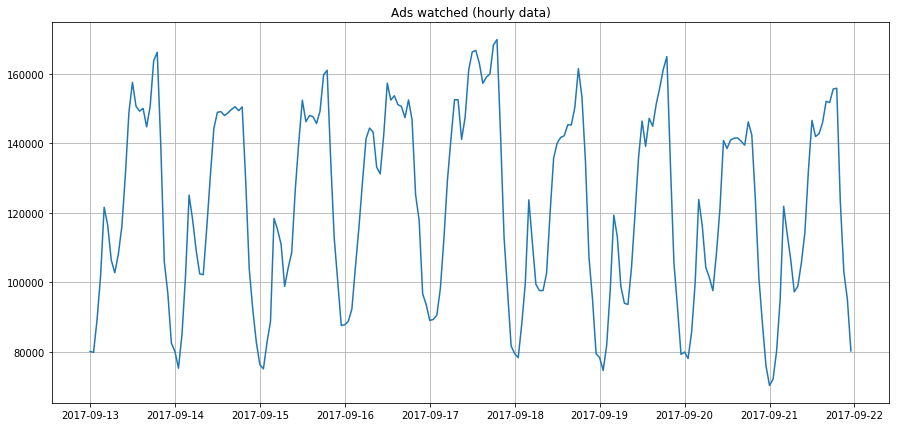

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
#plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

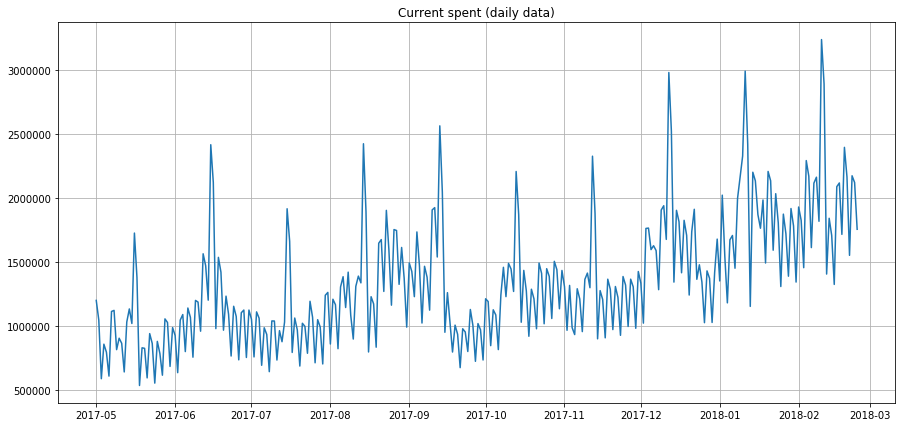

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Current spent (daily data)')
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Plot moving average ###

In [20]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "b", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], "g", label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

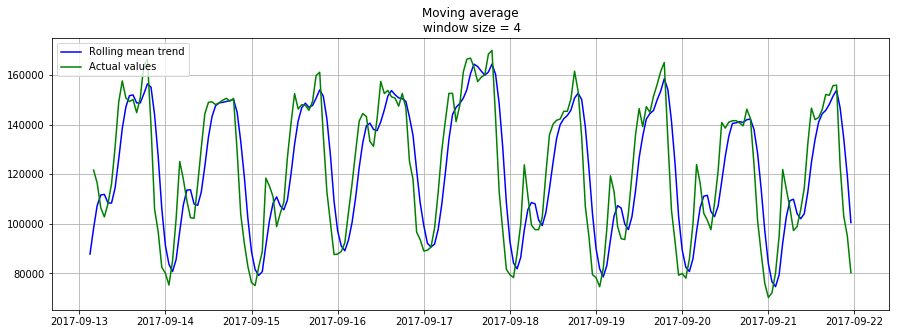

In [21]:
plotMovingAverage(ads, 4) 

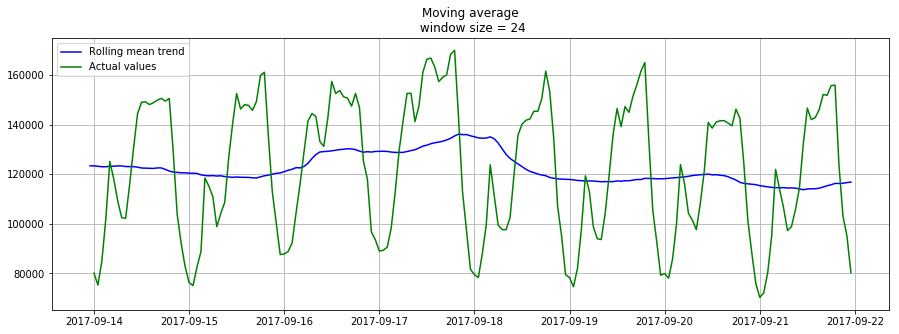

In [22]:
plotMovingAverage(ads, 24) 

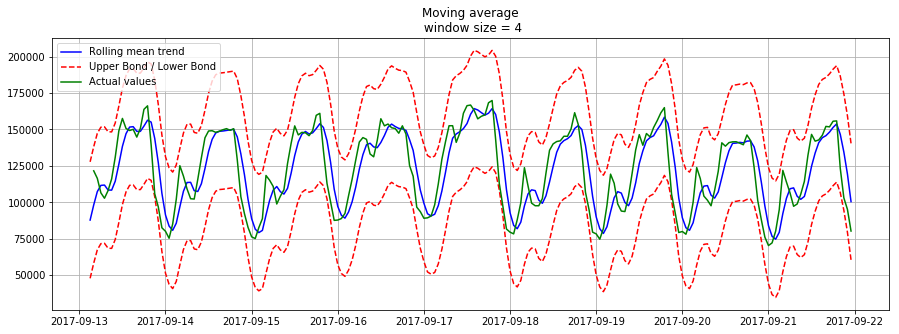

In [23]:
plotMovingAverage(ads, 4, plot_intervals=True, plot_anomalies=True) 

### Plot currencies ###

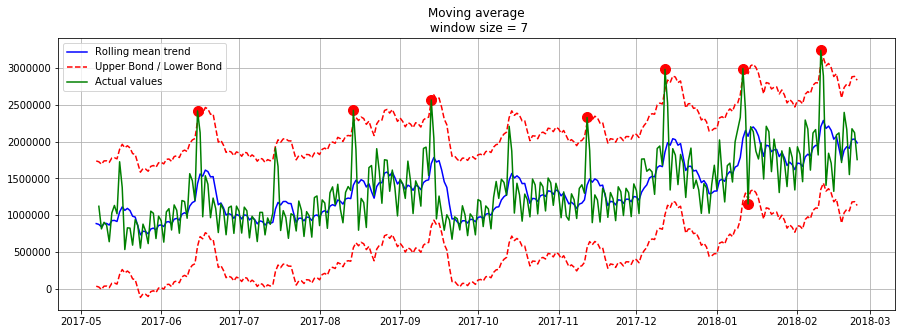

In [24]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

#### Moving averages does not handle the season peaks quite well ####

In [25]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [ ]:
weighted_average(ads, [0.6, 0.3, 0.1])

In [26]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [29]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "b", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

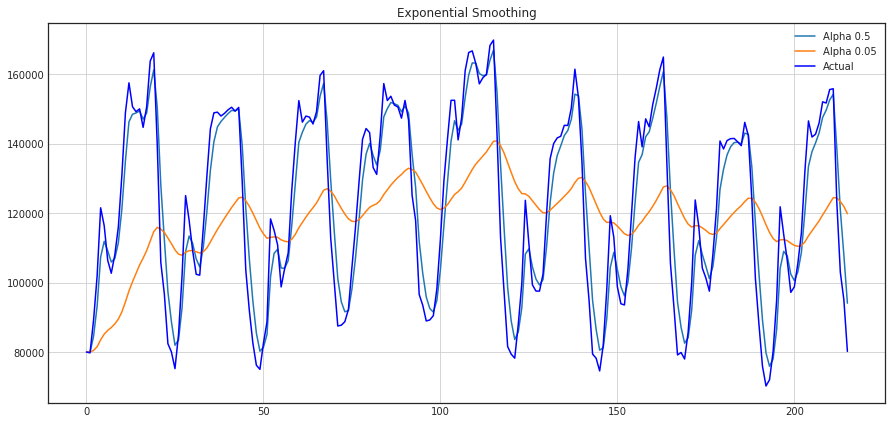

In [30]:
plotExponentialSmoothing(ads.Ads, [0.5, 0.05])

In [ ]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [ ]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9], betas=[0.9])

In [ ]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9], betas=[0.9])